In [39]:
from pathlib import Path
from typing import Union, Dict
import matplotlib.pyplot as plt
import pandas as pd
import re
from typing import Dict
import seaborn as sns
import numpy as np
from adjustText import adjust_text

In [134]:
def load_dataset(dataset_path: Union[str, Path]):
    if not isinstance(dataset_path, str) and not isinstance(dataset_path, Path):
        raise TypeError("dataset_path must be a Path object or string.")
    
    p = dataset_path if isinstance(dataset_path, Path) else Path(dataset_path)
    if not p.exists():
        raise FileNotFoundError(f"The dataset was not found at: {str(p)}")
    
    filename = p.name
    path = p.absolute().resolve()
    
    if filename.endswith((".parquet.gzip", ".parquet")):
        try:
            return pd.read_parquet(path, engine="fastparquet")
        except:
            return pd.read_parquet(path)
    elif filename.endswith(".json"):
        return pd.read_json(path)
    elif filename.endswith(".pkl"):
        return pd.read_pickle(path)
    raise ValueError(f"The provided dataset format is not taken in charge. Use json, parquet or pickle. Found: {filename}")

def load_dataset_and_preprocess(dataset_path: str):
    df = load_dataset(dataset_path)
    df_timeout = df.loc[df['execution'] == 'timeout']
    df_empty = df.drop(df_timeout.index).loc[df['execution'].str.startswith("[]")]
    df_fail = df.drop(df_timeout.index).drop(df_empty.index).loc[df['execution'].str.startswith('exception')]
    df_no_errors = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)
    
    return {
        "base": df,
        "timeout": df_timeout,
        "empty": df_empty,
        "fail": df_fail,
        "no_errors": df_no_errors
    }
    
def create_pie(ax, labels, data, title, colors, pctdistance=0.85, labeldistance=1.1, count_and_pct=True, autotexts_size=10, **kwargs):
    total = sum(data)
    def make_autopct(values):
        def my_autopct(pct):
            if count_and_pct:
                total = sum(values)
                val = int(round(pct*total/100.0))
                return f'{val:d}\n({pct:.1f}%)'
            else:
                return f'{pct:.1f}%'
        return my_autopct
    
    wedges, texts, autotexts = ax.pie(data, labels=labels, colors=colors, autopct=make_autopct(data), 
                                      startangle=90, pctdistance=pctdistance, labeldistance=labeldistance, 
                                      wedgeprops=dict(width=0.5),
                                      **kwargs)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    
    # Increase font size of the labels and percentages
    plt.setp(texts, size=12, weight="bold")
    plt.setp(autotexts, size=autotexts_size, weight="bold")

sns.set_theme(style="ticks", palette="colorblind")


In [3]:
path_to_original_executed_dataset = "../datasets/fq18_2/final_queries_1.1_modified_executed_no_limits.parquet.gzip"
# path_to_original_executed_dataset = "../outputs/final_queries_v1.1_full_execution_limit_10.parquet.gzip"
original_dataset = load_dataset_and_preprocess(path_to_original_executed_dataset)

In [4]:
path_to_final_executed_dataset = "../datasets/fq18_2/final_fq18_with_limit_10/generated_prompt-executed.parquet.gzip"
# path_to_final_executed_dataset = "../outputs/dataset_pipeline/final_fq18_with_limit_10/generated_prompt-executed.parquet.gzip"
final_dataset = load_dataset_and_preprocess(path_to_final_executed_dataset)

path_to_final_executed_dataset_no_limit = "../datasets/fq18_2/final_fq18_without_limit/generated_prompt-executed.parquet.gzip"
# path_to_final_executed_dataset_no_limit = "../outputs/dataset_pipeline/final_fq18_without_limit/generated_prompt-executed.parquet.gzip"
final_dataset_no_limit = load_dataset_and_preprocess(path_to_final_executed_dataset_no_limit)

In [68]:
palette = sns.color_palette('colorblind', n_colors=10).as_hex()
palette

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [56]:
color_dict = {
    "timeout": palette[8],
    "failed": palette[3],
    "empty": palette[7],
    "success": palette[2],
}

Original dataset:
Number of timed out requests: 133
Number of failed requests: 122
Number of empty responses: 109
Number of successful responses: 2415

Final dataset (with limit 10):
Number of timed out requests: 126
Number of failed requests: 46
Number of empty responses: 112
Number of successful responses: 2487

Final dataset (no limit):
Number of timed out requests: 126
Number of failed requests: 49
Number of empty responses: 111
Number of successful responses: 2485



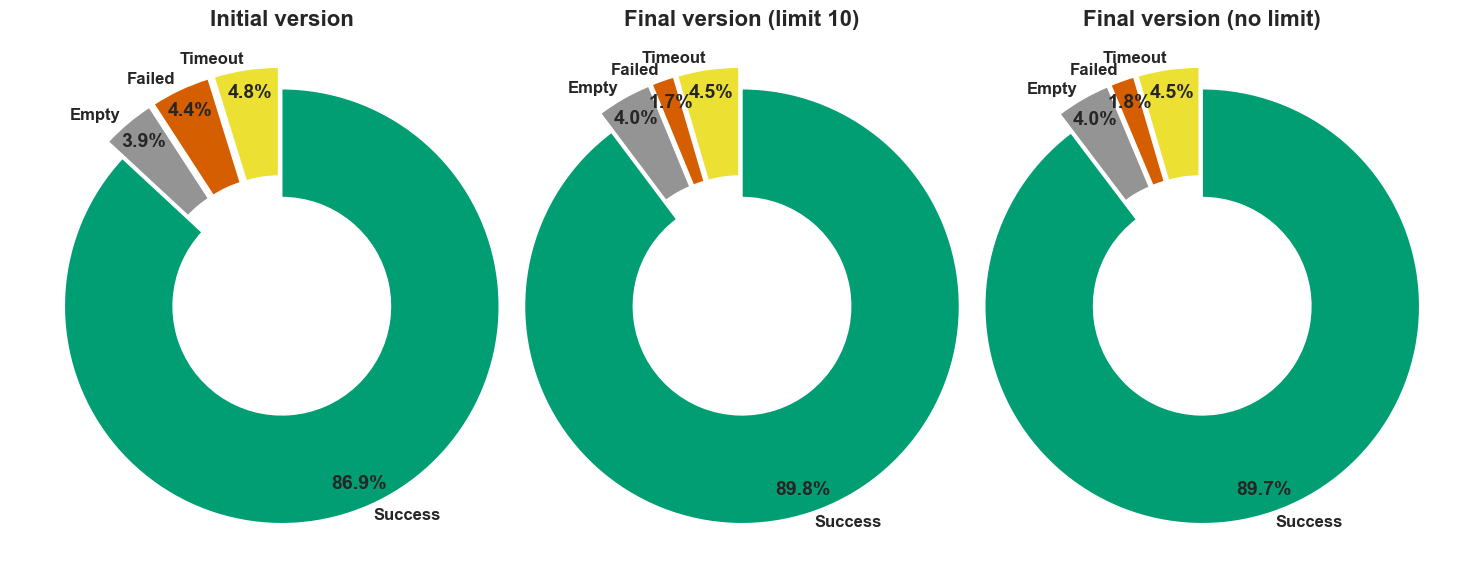

In [138]:
def analyze_queries_status_proportion(datasets, ax, title):
    print(f"Number of timed out requests: {len(datasets['timeout'])}")
    print(f"Number of failed requests: {len(datasets['fail'])}")
    print(f"Number of empty responses: {len(datasets['empty'])}")
    print(f"Number of successful responses: {len(datasets['no_errors'])}")

    labels = ["Timeout", "Failed", "Empty", "Success"]
    sizes  = [
        len(datasets['timeout']),
        len(datasets['fail']),
        len(datasets['empty']),
        len(datasets['no_errors'])
    ]
    
    colors = [
        color_dict['timeout'],
        color_dict['failed'],
        color_dict['empty'],
        color_dict['success'],
    ]

    # ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])
    create_pie(ax, labels, sizes, title, colors, explode=(0.1, 0.1, 0.1, 0.), pctdistance=0.89, labeldistance=1.05, count_and_pct=False, autotexts_size=14)
    
# Call the function with your dataframes as arguments
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 10)
print("Original dataset:")
analyze_queries_status_proportion(original_dataset, ax1, 'Initial version')
# ax1.set_title(label="Original dataset")
print()
print("Final dataset (with limit 10):")
analyze_queries_status_proportion(final_dataset, ax2, 'Final version (limit 10)')
# ax2.set_title(label="Final dataset (with limit 10)")
print()
print("Final dataset (no limit):")
analyze_queries_status_proportion(final_dataset_no_limit, ax3, 'Final version (no limit)')
# ax3.set_title(label="Final dataset (no limit)")
print()

plt.tight_layout(w_pad=-5.)
plt.show()

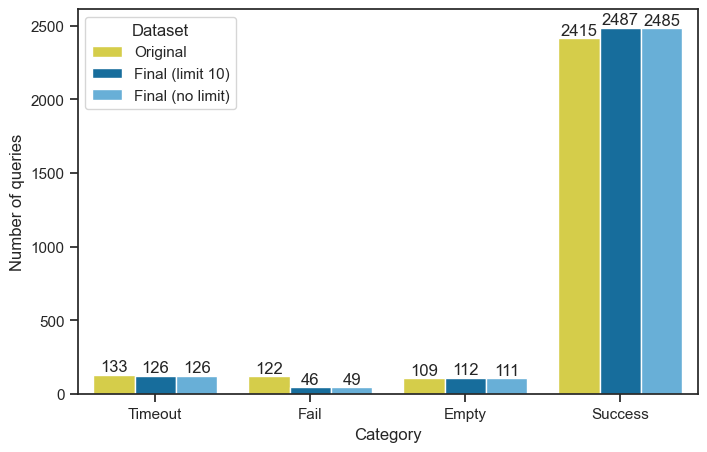


Original dataset:
Number of Timeout requests: 133
Number of Fail requests: 122
Number of Empty requests: 109
Number of Success requests: 2415

Final (limit 10) dataset:
Number of Timeout requests: 126
Number of Fail requests: 46
Number of Empty requests: 112
Number of Success requests: 2487

Final (no limit) dataset:
Number of Timeout requests: 126
Number of Fail requests: 49
Number of Empty requests: 111
Number of Success requests: 2485


In [130]:
def prepare_data_for_grouped_bars_category_per_dataset(datasets):
    category_mapping = {
        'timeout': 'Timeout',
        'fail': 'Fail',
        'empty': 'Empty',
        'no_errors': 'Success'
    }
    
    data = []
    for dataset_name, dataset in datasets.items():
        for category, pretty_category in category_mapping.items():
            data.append({
                'Dataset': dataset_name,
                'Category': pretty_category,
                'Count': len(dataset[category])
            })
    return pd.DataFrame(data)

# Prepare the data
datasets = {
    'Original': original_dataset,
    'Final (limit 10)': final_dataset,
    'Final (no limit)': final_dataset_no_limit
}
df = prepare_data_for_grouped_bars_category_per_dataset(datasets)

# Create the plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Category', y='Count', hue='Dataset', data=df, 
            # palette={'timeout': 'orange', 'fail': 'red', 'empty': 'grey', 'no_errors': 'green'}
            palette={'Final (limit 10)': palette[0], 'Final (no limit)': palette[9], 'Original': palette[8]}
            )

# plt.title('Query Status Proportion Across Datasets')
plt.xlabel('Category')
plt.ylabel('Number of queries')
plt.legend(title='Dataset')

# Add value labels on the bars
for i in plt.gca().containers:
    plt.gca().bar_label(i, label_type='edge')

plt.show()

# Print the counts
category_mapping = {
    'timeout': 'Timeout',
    'fail': 'Fail',
    'empty': 'Empty',
    'no_errors': 'Success'
}

for dataset_name, dataset in datasets.items():
    print(f"\n{dataset_name} dataset:")
    for category, pretty_category in category_mapping.items():
        print(f"Number of {pretty_category} requests: {len(dataset[category])}")

In [8]:
def find_error_type(x: str):
    if not isinstance(x, str):
        return None
    
    http_error = re.compile(r"exception: ([0-9]+)")
    module_request_error = re.compile(r"exception: module 'requests.exceptions'")
    server_timeout_error = re.compile(r"java.util.concurrent.TimeoutException")
    empty_error = re.compile(r"exception: query is empty")
    
    http_error_match = http_error.search(x[:20])
    
    if http_error_match != None:
        return http_error_match.group(1)
    
    if module_request_error.search(x[:50]):
        return "requests"
    
    if server_timeout_error.search(x[len(x)-10000:]):
        return "server timeout"
    
    if empty_error.search(x[:100]):
        return "empty query"
    
    return None

def analyse_errors(datasets: Dict):
    datasets['fail']['error_type'] = datasets['fail'].apply(lambda x: find_error_type(x['execution']), axis=1)

    distinct_errors = datasets['fail'].error_type.unique()

    print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
    for err in distinct_errors:
        if err == None:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'].isnull()])}")
        else:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'] == err])}")

    for err in distinct_errors:
        if err == None:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'].isnull()].iloc[0]['execution'][:256]}")
        else:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'] == err].iloc[0]['execution'][:256]}")

In [9]:
# CAUTION! If there is a link provided in the example, it may be truncated. Therefore leading to another error message !!
# It is truncated for presentation purposes.
print("Original dataset:")
analyse_errors(original_dataset)
print()

print("Final dataset (with limit 10):")
analyse_errors(final_dataset)
print()

print("Final dataset (no limit):")
analyse_errors(final_dataset_no_limit)
print()

Original dataset:
There is 2 types of errors: 500, 400
Number of 500: 45
Number of 400: 77
Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of 400: exception: 400 Client Error: Bad Request for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+schema%3A+%3Chttp%3A%2F%2Fschema.org%2F%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+wdt%3A+%3Chttp%3A

Final dataset (with limit 10):
There is 2 types of errors: 500, 400
Number of 500: 42
Number of 400: 4
Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APR

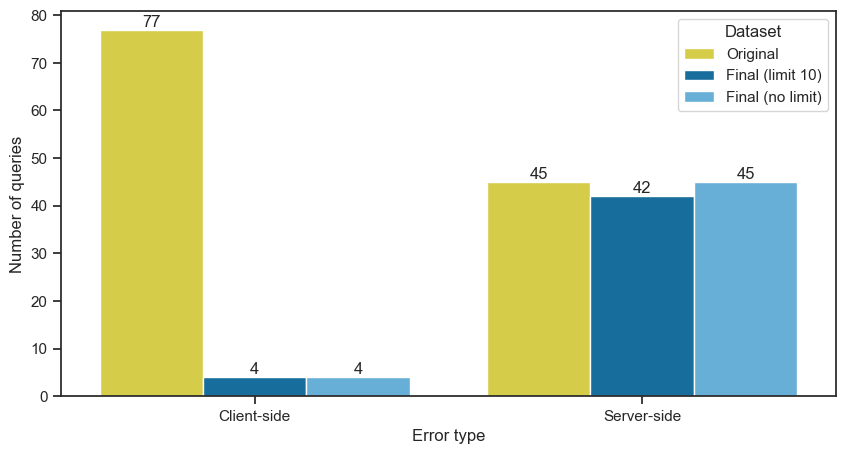


Original dataset:
Number of Client-side requests: 77
Number of Server-side requests: 45

Final (limit 10) dataset:
Number of Client-side requests: 4
Number of Server-side requests: 42

Final (no limit) dataset:
Number of Client-side requests: 4
Number of Server-side requests: 45


In [79]:
tmp_ori = original_dataset['fail']['error_type'].value_counts().to_dict()
tmp_f10 = final_dataset['fail']['error_type'].value_counts().to_dict()
tmp_fin = final_dataset_no_limit['fail']['error_type'].value_counts().to_dict()

def prepare_data_for_grouped_bars_errors_per_dataset(datasets):
    category_mapping = {
        '400': 'Client-side',
        '500': 'Server-side',
    }
    
    data = []
    for dataset_name, dataset in datasets.items():
        for category, pretty_category in category_mapping.items():
            data.append({
                'Dataset': dataset_name,
                'Category': pretty_category,
                'Count': dataset[category]
            })
    return pd.DataFrame(data)

# Prepare the data
datasets = {
    'Original': tmp_ori,
    'Final (limit 10)': tmp_f10,
    'Final (no limit)': tmp_fin
}
df = prepare_data_for_grouped_bars_errors_per_dataset(datasets)

# Create the plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Category', y='Count', hue='Dataset', data=df, 
            # palette={'timeout': 'orange', 'fail': 'red', 'empty': 'grey', 'no_errors': 'green'}
            palette={'Final (limit 10)': palette[0], 'Final (no limit)': palette[9], 'Original': palette[8]}
            )

# plt.title('Query Status Proportion Across Datasets')
plt.xlabel('Error type')
plt.ylabel('Number of queries')
plt.legend(title='Dataset')

# Add value labels on the bars
for i in plt.gca().containers:
    plt.gca().bar_label(i, label_type='edge')

plt.show()

# Print the counts
category_mapping = {
        '400': 'Client-side',
        '500': 'Server-side',
    }

for dataset_name, dataset in datasets.items():
    print(f"\n{dataset_name} dataset:")
    for category, pretty_category in category_mapping.items():
        print(f"Number of {pretty_category} requests: {dataset[category]}")

Original dataset:
error_type
400    77
500    45
Name: count, dtype: int64

Final dataset (with limit 10):
error_type
500    42
400     4
Name: count, dtype: int64

Final dataset (no limit):
error_type
500    45
400     4
Name: count, dtype: int64


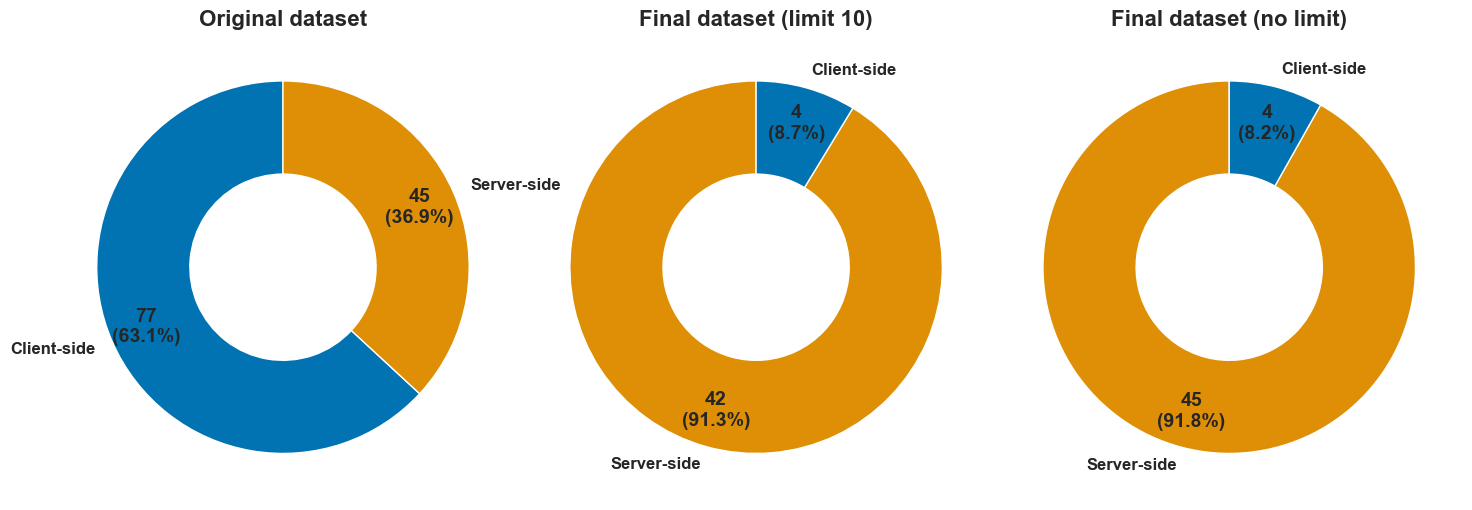

In [144]:
def plot_error_types(datasets: Dict, ax, titles):
    labels_map = {
        "400": "Client-side",
        "500": "Server-side"
    }
    
    colors = {
        "400": palette[0],
        "500": palette[1]
    }
    value_counts = datasets['fail']['error_type'].value_counts()
    print(value_counts)

    labels = list(datasets['fail']['error_type'].value_counts().index)
    sizes = list(value_counts)
    
    create_pie(ax, [labels_map[x] for x in labels], sizes, titles, [colors[x] for x in labels], pctdistance=0.8, autotexts_size=14)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 20)

print("Original dataset:")
plot_error_types(original_dataset, ax1, "Original dataset")
print()

print("Final dataset (with limit 10):")
plot_error_types(final_dataset, ax2, "Final dataset (limit 10)")
print()

print("Final dataset (no limit):")
plot_error_types(final_dataset_no_limit, ax3, "Final dataset (no limit)")

plt.tight_layout(w_pad=-3.)

In [12]:
def generate_index_of_errors(all_errors: pd.Series):
    error_types = sorted(list(all_errors.value_counts().index))
    return {x[0]: i for i, x in enumerate(error_types)}

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    pattern_multiple_same_prefixes = re.compile(r"Multiple prefix declarations for prefix")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
    if pattern_multiple_same_prefixes.search(last_error):
        errors.append("Prefix duplicates")
        
    return errors

def classify_500_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_stackoverflow = re.compile(r"StackOverflowError")
    pattern_geo_input_no_resolve_point = re.compile(r"Input could not be resolved as point")
    pattern_estimated_time_too_long = re.compile(r"The estimated execution time")
    pattern_out_of_memory = re.compile(r"MemoryManagerOutOfMemory")
    pattern_nullpointerexception = re.compile(r"java.lang.NullPointerException")
    pattern_invalid_json_error = re.compile(r"exception: 500 Server Error: the response has an Invalid chunk length")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1] if len(reduced_stack) > 0 else ""
    
    errors = []
    if pattern_stackoverflow.search(last_error):
        errors.append("stack overflow")
    if pattern_geo_input_no_resolve_point.search(last_error):
        errors.append("GeoSpatialSearchException: input could not be resolved as point")
    if pattern_estimated_time_too_long.search(last_error):
        errors.append("estimated time to execute too long")
    if pattern_out_of_memory.search(last_error):
        errors.append("Out of memory")
    if pattern_nullpointerexception.search(last_error):
        errors.append("NullPointerException")
    if pattern_invalid_json_error.search(stack_trace):
        errors.append("Invalid JSON")
        
    return errors

def classify_requests_errors(execution_result):
    pattern = re.compile(r"exception: module 'requests.exceptions' has no attribute 'JSONDecodeError'")
    errors = []
    
    if pattern.search(execution_result[:100]):
        errors.append("no attribute 'JSONDecodeError'")
    
    return errors


def classify_all_errors(execution_result: str):
    if not isinstance(execution_result, str) or execution_result == None:
        return None
    
    error = find_error_type(execution_result)
    
    
    if error == None:
        return None
    elif error == "400":
        return classify_400_errors(execution_result)
    elif error == "500":
        return classify_500_errors(execution_result)
    elif error == "requests":
        return classify_requests_errors(execution_result)
    elif error == "server timeout":
        return ["server timeout"]
    elif error == "empty query":
        return ['empty query']
    
    
    raise NotImplementedError(f"This function is not implemented for errors other than 400, 500, requests, invalid JSON, server timeout, found: {error}")

ERROR_INDEX = {
    "undefined prefix": 0,
    "parse exception due to limit": 1,
    "parse exception": 2,
    "lexical error": 3,
    "non-aggregate variable in select expression": 4,
    "Prefix duplicates": 5,
    "stack overflow": 6,
    "GeoSpatialSearchException: input could not be resolved as point": 7,
    "estimated time to execute too long": 8,
    "Out of memory": 9,
    "no attribute 'JSONDecodeError'": 10,
    "Invalid JSON": 11,
    "server timeout": 12,
    "NullPointerException": 13,
    "empty query": 14
}

original_dataset['fail']['error_classified'] = original_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
original_dataset['fail']['ierror_classified'] = original_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset['fail']['error_classified'] = final_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset['fail']['ierror_classified'] = final_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset_no_limit['fail']['error_classified'] = final_dataset_no_limit['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset_no_limit['fail']['ierror_classified'] = final_dataset_no_limit['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

Original dataset:
error_classified
[lexical error]                                  33
[undefined prefix]                               27
[parse exception]                                16
[non-aggregate variable in select expression]     1
Name: count, dtype: int64

Final dataset (with limit 10):
error_classified
[parse exception]                 3
[parse exception due to limit]    1
Name: count, dtype: int64

Final dataset (no limit):
error_classified
[parse exception]    4
Name: count, dtype: int64


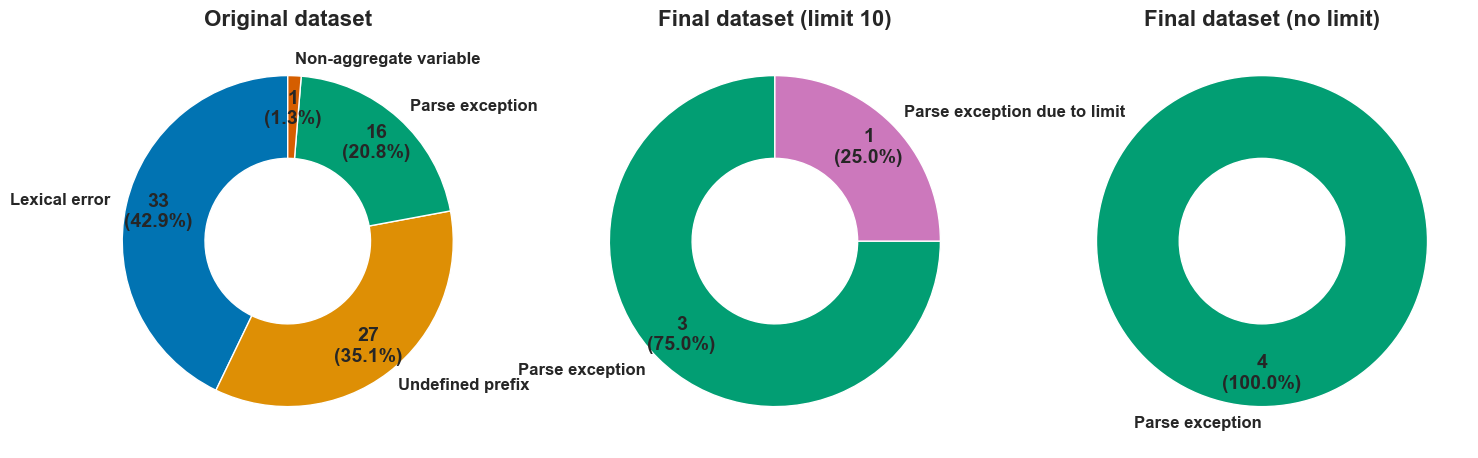

In [148]:
def plot_error_400(datasets, ax, title):
    category = {
        "lexical error": "Lexical error",
        "undefined prefix": "Undefined prefix",
        "parse exception": "Parse exception",
        "non-aggregate variable in select expression": "Non-aggregate variable",
        "parse exception due to limit": "Parse exception due to limit",
    }
    
    colors = {
        "lexical error": palette[0],
        "undefined prefix": palette[1],
        "parse exception": palette[2],
        "non-aggregate variable in select expression": palette[3],
        "parse exception due to limit": palette[4],
    }
    
    df_error400 = datasets['fail'].loc[datasets['fail']['error_type'] == '400']

    value_counts = df_error400.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error400.error_classified.value_counts().index)))
    sizes = list(value_counts)

    create_pie(ax, [category[x] for x in labels], sizes, title, [colors[x] for x in labels], pctdistance=0.8, autotexts_size=14)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 20))

print("Original dataset:")
plot_error_400(original_dataset, ax1, "Original dataset")
print()

print("Final dataset (with limit 10):")
plot_error_400(final_dataset, ax2, "Final dataset (limit 10)")
print()

print("Final dataset (no limit):")
plot_error_400(final_dataset_no_limit, ax3, "Final dataset (no limit)")
plt.tight_layout(w_pad=-5.)

Original dataset:
error_classified
[stack overflow]                                                     33
[GeoSpatialSearchException: input could not be resolved as point]     7
[Invalid JSON]                                                        3
[Out of memory]                                                       2
Name: count, dtype: int64

Final dataset (with limit 10):
error_classified
[stack overflow]                                                     34
[GeoSpatialSearchException: input could not be resolved as point]     7
[Out of memory]                                                       1
Name: count, dtype: int64

Final dataset (no limit):
error_classified
[stack overflow]                                                     34
[GeoSpatialSearchException: input could not be resolved as point]     7
[Out of memory]                                                       3
[Invalid JSON]                                                        1
Name: count, dtype: int64


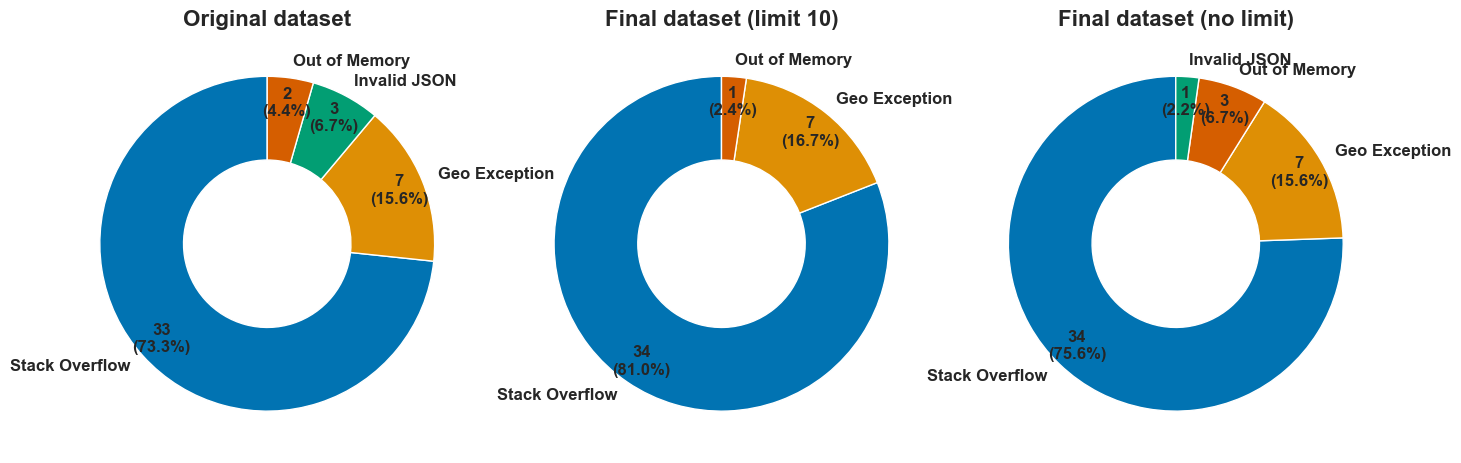

In [157]:
def plot_error_500(datasets, ax, title):
    category = {
        "stack overflow": "Stack Overflow",
        "GeoSpatialSearchException: input could not be resolved as point": "Geo Exception",
        "Invalid JSON": "Invalid JSON",
        "Out of memory": "Out of Memory",
    }
    
    colors = {
        "stack overflow": palette[0],
        "GeoSpatialSearchException: input could not be resolved as point": palette[1],
        "Invalid JSON": palette[2],
        "Out of memory": palette[3],
    }
    
    df_error500 = datasets['fail'].loc[datasets['fail']['error_type'] == '500']

    value_counts = df_error500.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error500.error_classified.value_counts().index)))
    sizes = list(value_counts)

    create_pie(ax, [category[x] for x in labels], sizes, title, [colors[x] for x in labels], pctdistance=0.85, autotexts_size=12)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 20))
print("Original dataset:")
plot_error_500(original_dataset, ax1, "Original dataset")
print()

print("Final dataset (with limit 10):")
plot_error_500(final_dataset, ax2, "Final dataset (limit 10)")
print()

print("Final dataset (no limit):")
plot_error_500(final_dataset_no_limit, ax3, "Final dataset (no limit)")

plt.tight_layout(w_pad=-5.)